# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [2]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

In [3]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

# global variables
model_counter = 0

2023-12-03 02:32:04.435 | INFO     | preprocessing:__init__:58 - --- Executing Preprocessing Steps ---
2023-12-03 02:32:04.436 | INFO     | preprocessing:make_combined_df:146 - Loading csv files
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:151: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:151: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:151: DtypeWarning: Columns (37,179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,2

##### General functions

In [20]:
def get_sample(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df):
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def plot_predicts(y_test, predictions, label):
    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def plot_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

def plot_feature_importances(pipeline, label, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.show()

##### Functions for cross validation

In [5]:
def test_model(pipeline, df, data_fraction: float = None, label = None):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    plot_predicts(y_test, predictions, label if label else '')
    save_model(features, target, predictions, label, title_appendix=f'normal_{data_fraction*100}%_of_data')

    return y_test, predictions

def test_model_k_fold(df, pipeline, label, k_folds: int=3, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)

    cv_predictions = cross_val_predict(pipeline, features, target, cv=k_folds)
    
    plot_predicts(target, cv_predictions, label)
    save_model(features, target, cv_predictions, label, title_appendix=f'{k_folds}_folds_{data_fraction*100}%_of_data')
    return cv_predictions

def estimate_hyperparams(df, pipeline, scoring, k_folds=3, parameters={}, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False, n_jobs=1)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    display(grid_search_estimator.best_params_)
    display(pd.DataFrame(grid_search_estimator.cv_results_))

    return grid_search_estimator

def generate_param_combinations(parameters):
    '''list of list required for cross product of two lists'''
    return list(ParameterGrid(parameters))

def save_model(features, target, predictions, label, title_appendix: str = ''):
    global model_counter

    predictions_df = pd.DataFrame({'predicted yards_gained': predictions})
    save_model = pd.concat([features, target, predictions_df], axis=1)

    if (title_appendix != ''):
        title_appendix = '_'+title_appendix
    save_model.to_excel(f'./results/model_{model_counter}_{label}{title_appendix}.xlsx')

    # increase counter for files
    model_counter = model_counter + 1
    pass

##### MLP Regressor Class - with history

In [6]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [15]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

(340092, 24)
(444089, 24)


### Linear Regression

2023-12-03 12:08:32.910 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo']


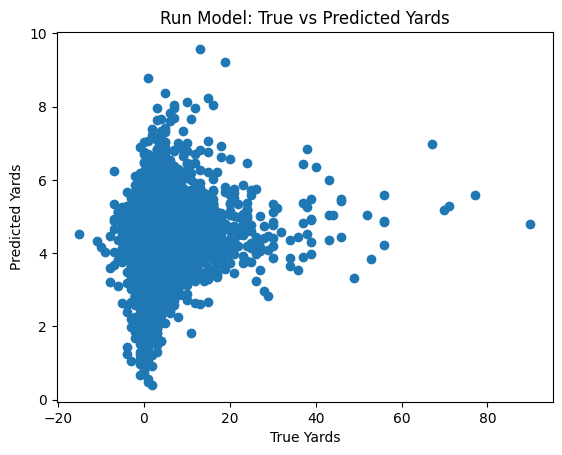

Mean Squared Error: 41.76111580292873
Mean Absolute Error: 3.896723421366242
Root Mean Squared Error: 6.462284101068965


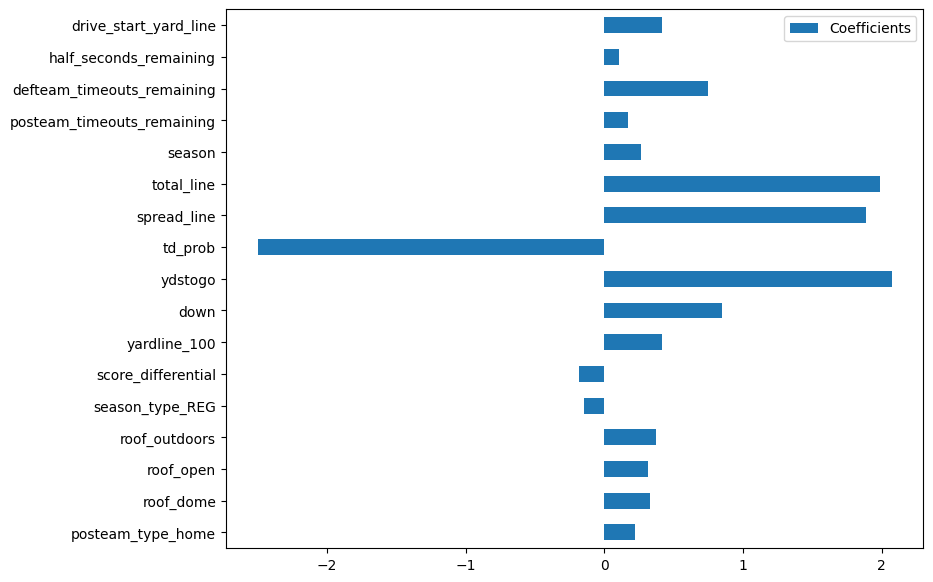

2023-12-03 12:08:37.260 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['ydstogo']


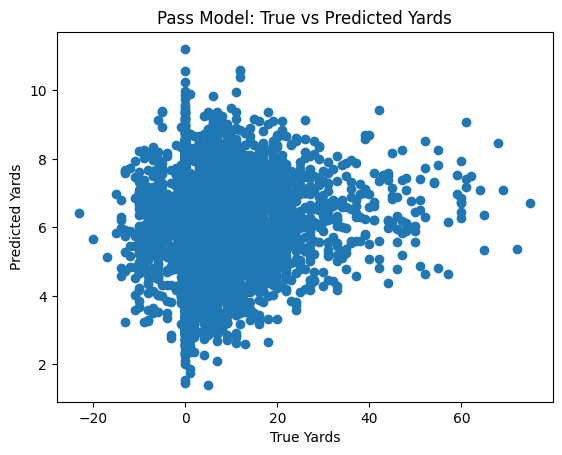

Mean Squared Error: 95.18299879946763
Mean Absolute Error: 6.952746053785409
Root Mean Squared Error: 9.756177468633277


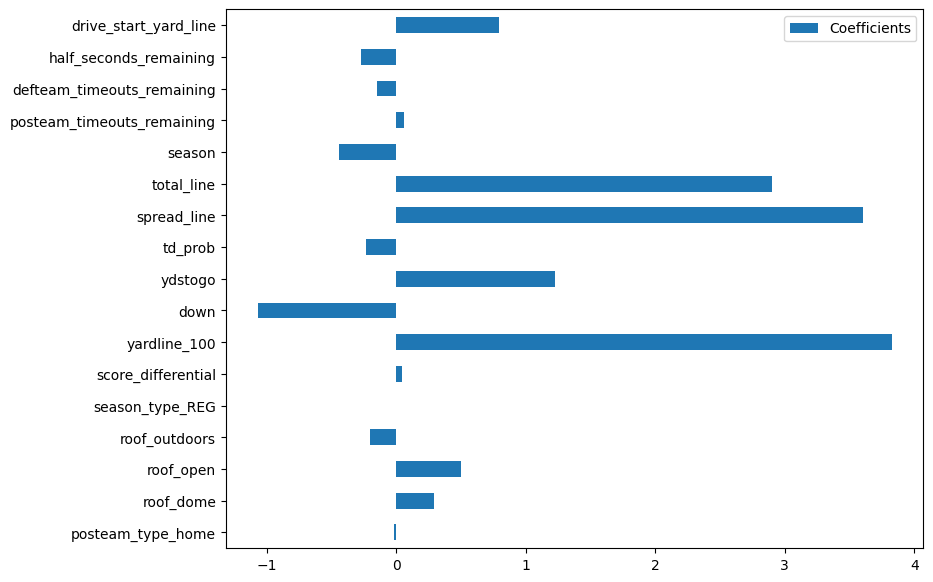

In [21]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df, 0.05, label=LABEL_RUN)
plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 0.05, label=LABEL_PASS)
plot_coef(pipeline)

In [ ]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=run_params, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=pass_params, data_fraction=0.25)

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Polynomial Regression

2023-12-03 12:05:50.685 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


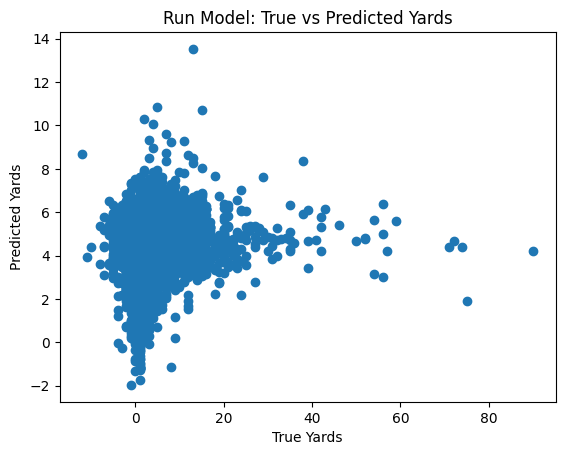

Mean Squared Error: 40.47622939123688
Mean Absolute Error: 3.8418654340511207
Root Mean Squared Error: 6.362093161156702


2023-12-03 12:05:54.427 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


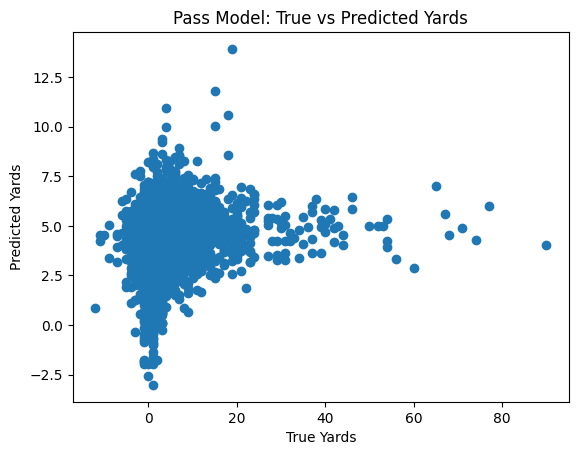

Mean Squared Error: 43.340889137566634
Mean Absolute Error: 3.8715560106685
Root Mean Squared Error: 6.583379765558617


In [16]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)

In [11]:
# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)

2023-12-03 11:39:08.629 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:09.270 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:09.853 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:10.381 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:14.168 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:17.874 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:21.643 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.469335,0.040449,0.040457,0.008003,2,{'regressor__polynomialfeatures__degree': 2},-6.220524,-6.174403,-6.479262,-6.291396,0.134169,1
1,3.515304,0.043620,0.163636,0.008210,3,{'regressor__polynomialfeatures__degree': 3},-6.263465,-6.218098,-6.520883,-6.334149,0.133334,2


2023-12-03 11:39:22.516 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:23.138 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:23.781 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:24.443 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:29.091 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:33.718 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:38.161 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.535485,0.013218,0.045421,0.001078,2,{'regressor__polynomialfeatures__degree': 2},-9.923722,-9.896953,-9.816738,-9.879138,0.045457,1
1,4.294839,0.117067,0.202688,0.003073,3,{'regressor__polynomialfeatures__degree': 3},-10.007820,-9.978777,-9.890531,-9.959043,0.049875,2


2023-12-03 11:39:48.409 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:51.259 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:39:54.104 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


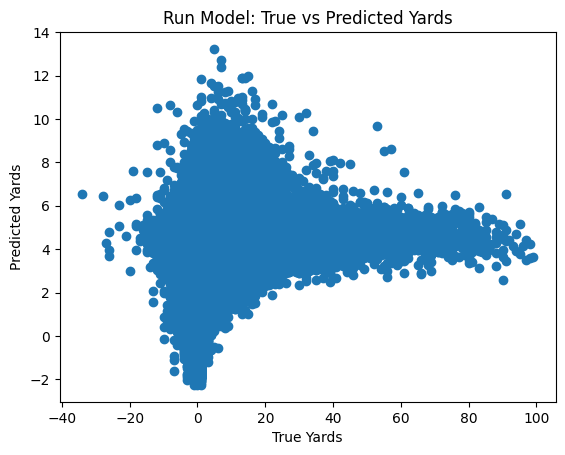

Mean Squared Error: 38.670682861424815
Mean Absolute Error: 3.769979329220831
Root Mean Squared Error: 6.218575629629732


2023-12-03 11:41:14.841 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:41:18.291 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 11:41:21.675 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


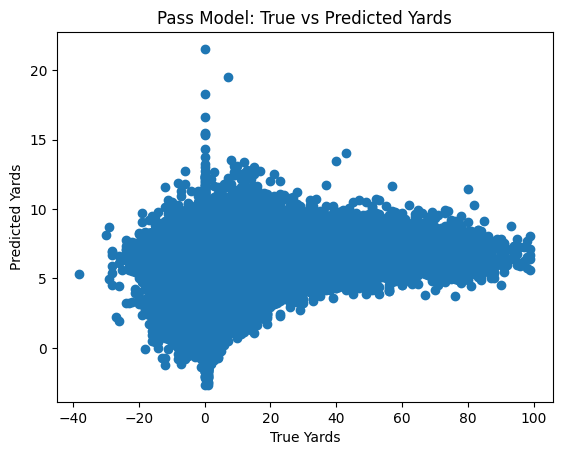

Mean Squared Error: 97.34939703699344
Mean Absolute Error: 7.012299840447964
Root Mean Squared Error: 9.866579804420246


In [12]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### KNN

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.2)

In [8]:
# estimating hyperparameters
parameters = {
    'regressor__n_neighbors': range(5,10),
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=1.0)

2023-12-03 02:33:23.512 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:33:32.043 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:33:40.506 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:33:49.055 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:33:57.556 | IN

{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.364856,0.086631,8.081397,0.087120,"{'strict_columns': ['yardline_100', 'ydstogo',...",5,{'outlier_remover__kw_args': {'strict_columns'...,-6.705732,-6.914224,-6.889790,-6.836582,0.093061,10
1,0.304199,0.005720,8.120448,0.035652,"{'strict_columns': ['yardline_100', 'ydstogo',...",6,{'outlier_remover__kw_args': {'strict_columns'...,-6.605042,-6.815160,-6.790831,-6.737011,0.093843,8
2,0.307953,0.012275,8.125637,0.071833,"{'strict_columns': ['yardline_100', 'ydstogo',...",7,{'outlier_remover__kw_args': {'strict_columns'...,-6.533039,-6.743304,-6.718611,-6.664985,0.093843,6
3,0.353170,0.065633,8.087130,0.086420,"{'strict_columns': ['yardline_100', 'ydstogo',...",8,{'outlier_remover__kw_args': {'strict_columns'...,-6.481758,-6.684027,-6.664517,-6.610100,0.091101,4
4,0.306558,0.002003,8.092175,0.099316,"{'strict_columns': ['yardline_100', 'ydstogo',...",9,{'outlier_remover__kw_args': {'strict_columns'...,-6.434967,-6.639702,-6.623091,-6.565920,0.092846,2
5,0.302583,0.003279,9.145480,0.074668,{'strict_columns': []},5,{'outlier_remover__kw_args': {'strict_columns'...,-6.702959,-6.884745,-6.846856,-6.811520,0.078307,9
6,0.304121,0.006636,9.149717,0.047936,{'strict_columns': []},6,{'outlier_remover__kw_args': {'strict_columns'...,-6.607692,-6.787843,-6.747258,-6.714264,0.077158,7
7,0.362181,0.091068,9.147181,0.063349,{'strict_columns': []},7,{'outlier_remover__kw_args': {'strict_columns'...,-6.536829,-6.717092,-6.685064,-6.646329,0.078524,5
8,0.301624,0.006529,9.171428,0.058428,{'strict_columns': []},8,{'outlier_remover__kw_args': {'strict_columns'...,-6.476219,-6.665691,-6.634861,-6.592257,0.083011,3
9,0.300279,0.004355,9.188154,0.097281,{'strict_columns': []},9,{'outlier_remover__kw_args': {'strict_columns'...,-6.432184,-6.625837,-6.594761,-6.550927,0.084917,1


2023-12-03 02:37:54.779 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:38:07.669 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:38:20.535 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:38:33.368 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall']
2023-12-03 02:38:46.346 | IN

{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.444747,0.080653,12.349391,0.081326,"{'strict_columns': ['yardline_100', 'ydstogo',...",5,{'outlier_remover__kw_args': {'strict_columns'...,-10.754488,-10.970605,-10.891987,-10.872360,0.089314,10
1,0.390138,0.003343,12.475918,0.137240,"{'strict_columns': ['yardline_100', 'ydstogo',...",6,{'outlier_remover__kw_args': {'strict_columns'...,-10.593295,-10.818327,-10.733340,-10.714987,0.092781,8
2,0.382159,0.005368,12.445053,0.106974,"{'strict_columns': ['yardline_100', 'ydstogo',...",7,{'outlier_remover__kw_args': {'strict_columns'...,-10.477059,-10.703898,-10.612178,-10.597712,0.093170,6
3,0.383951,0.002458,12.473002,0.045101,"{'strict_columns': ['yardline_100', 'ydstogo',...",8,{'outlier_remover__kw_args': {'strict_columns'...,-10.393923,-10.618037,-10.519468,-10.510476,0.091715,4
4,0.455101,0.092939,12.499990,0.097123,"{'strict_columns': ['yardline_100', 'ydstogo',...",9,{'outlier_remover__kw_args': {'strict_columns'...,-10.327491,-10.552460,-10.453127,-10.444360,0.092052,2
5,0.394583,0.001643,15.203052,0.026296,{'strict_columns': []},5,{'outlier_remover__kw_args': {'strict_columns'...,-10.694024,-10.948504,-10.881227,-10.841252,0.107668,9
6,0.389774,0.007800,15.227457,0.082351,{'strict_columns': []},6,{'outlier_remover__kw_args': {'strict_columns'...,-10.549728,-10.806438,-10.719826,-10.691997,0.106633,7
7,0.395341,0.001800,15.213965,0.045665,{'strict_columns': []},7,{'outlier_remover__kw_args': {'strict_columns'...,-10.443534,-10.699865,-10.600819,-10.581406,0.105543,5
8,0.468332,0.100534,15.335267,0.034533,{'strict_columns': []},8,{'outlier_remover__kw_args': {'strict_columns'...,-10.361129,-10.617228,-10.513634,-10.497330,0.105186,3
9,0.393785,0.001379,15.301416,0.104306,{'strict_columns': []},9,{'outlier_remover__kw_args': {'strict_columns'...,-10.292736,-10.546518,-10.446086,-10.428447,0.104354,1


2023-12-03 08:52:22.141 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 08:52:31.591 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 08:52:41.084 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


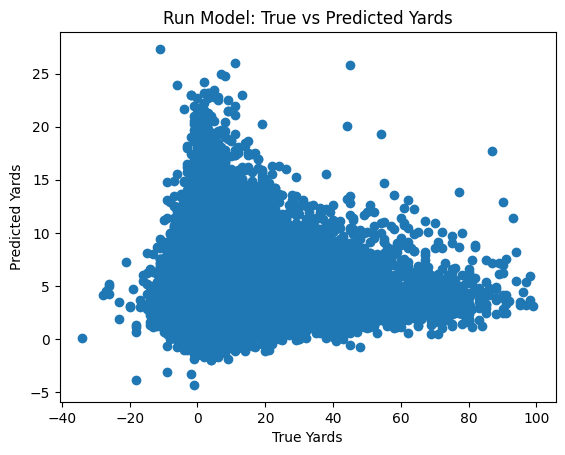

Mean Squared Error: 42.921857418972905
Mean Absolute Error: 4.085458901970316
Root Mean Squared Error: 6.551477498928994


2023-12-03 08:54:00.732 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 08:54:16.561 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []
2023-12-03 08:54:32.295 | INFO     | preprocessing:outlier_sampler_iqr:344 - >>> strict_columns: []


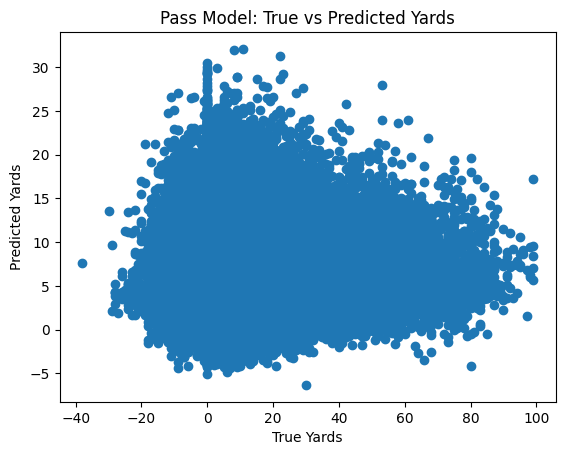

Mean Squared Error: 108.76339010456948
Mean Absolute Error: 7.446286917962638
Root Mean Squared Error: 10.428968793920589


In [9]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Random Forest

In [ ]:
# Basic model

# make pipelines

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)
plot_feature_importances(run_pipeline, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 7),
    'regressor__n_estimators': [20, 50, 100]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### XGBoost

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [8, 10],
    "regressor__n_estimators": [1000, 1100],
    "regressor__learning_rate": [0.022, 0.015]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Artificial Neuronal Network

In [ ]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
plot_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
plot_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [ ]:
parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
}
parameters

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
    #[
    #    {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)